In [1]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

import torch

import matplotlib.pyplot as plt
import random

from data import Sen2Dataset
from models import HFN_Default

In [2]:
BATCH_SIZE = 1
DATASET_ROOT = '/home/msiau/data/tmp/agarciat/Sentinel-2'

In [3]:
class Sen2Normalization(object):
    def __call__(self, image: torch.Tensor) -> torch.Tensor:
        return image / 10000.0

In [4]:
def visualize_image(image: torch.Tensor, patch_size: int = None):
    """Visualize image or a patch of the image"""
    image = torch.clamp(image, 0, 1)
    image = image[[2, 1, 0], :, :]
    
    if patch_size:
        image = image[:, :patch_size, :patch_size]
    
    plt.imshow(image.permute(1, 2, 0))
    plt.show()

def visualize_images_grid(images: list[torch.Tensor], patch_sizes: list[int] = None, titles: list[str] = None):
    """Visualize N images in a 1xN grid with optional titles"""
    n_images = len(images)
    fig, axes = plt.subplots(1, n_images, figsize=(n_images * 5, 5))
    
    for i, image in enumerate(images):
        image = torch.clamp(image, 0, 1)
        image = image[[2, 1, 0], :, :] if image.shape[0] >= 3 else image[0, :, :].squeeze()
        
        if patch_sizes and i < len(patch_sizes):
            patch_size = patch_sizes[i]
            image = image[:, :patch_size, :patch_size] if image.ndim == 3 else image[:patch_size, :patch_size]
        
        axes[i].imshow(image.permute(1, 2, 0) if image.ndim == 3 else image)
        axes[i].axis('off')
        
        if titles and i < len(titles):
            axes[i].set_title(titles[i])
    
    plt.show()

### Bicubic Upsampling

/home/msiau/data/tmp/agarciat/Sentinel-2/test/rasters
/home/msiau/data/tmp/agarciat/Sentinel-2/test/rasters/R10m
/home/msiau/data/tmp/agarciat/Sentinel-2/test/rasters/R20m
/home/msiau/data/tmp/agarciat/Sentinel-2/test/rasters/R60m


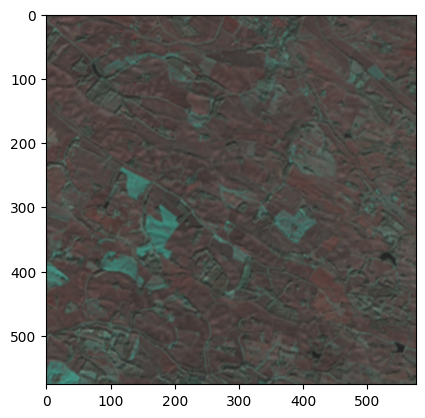

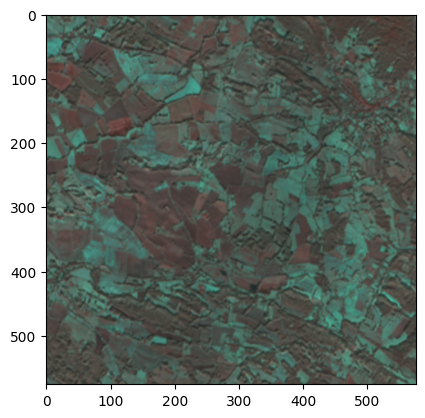

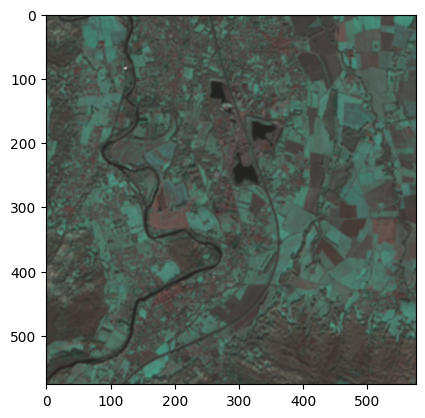

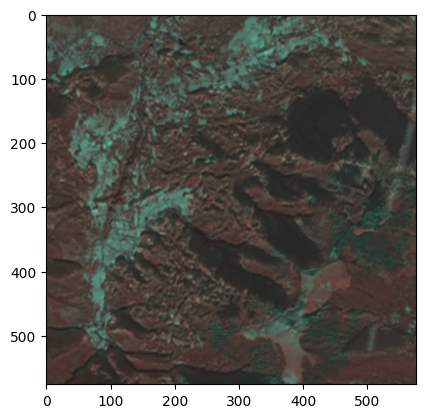

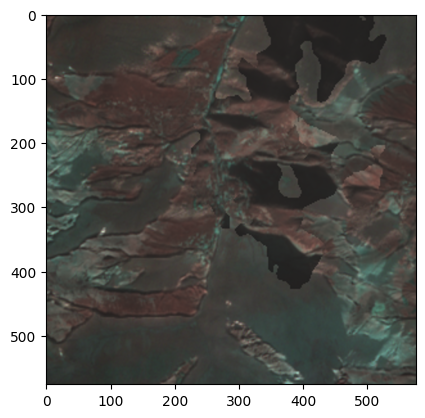

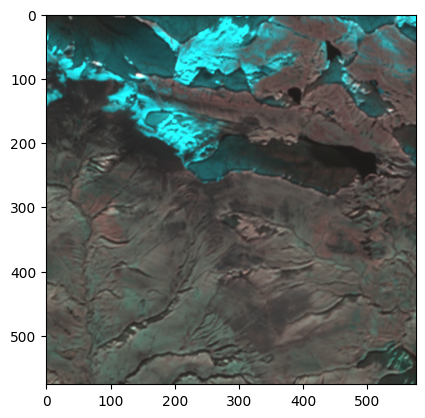

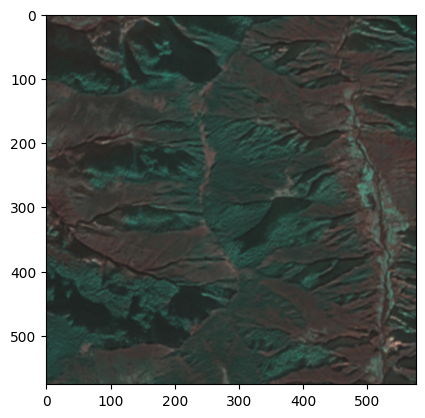

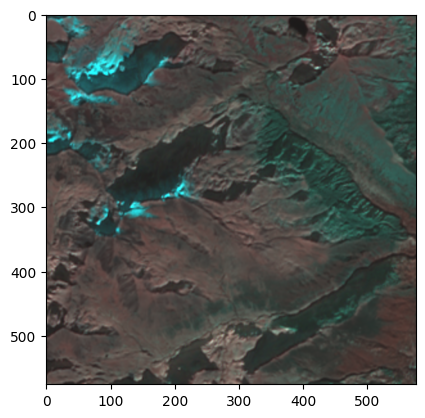

In [5]:
set_path = os.path.join(DATASET_ROOT, 'test')
src_path = os.path.join(set_path, 'rasters')
processed_path = os.path.join(set_path, 'bicubic_data')

dataset = Sen2Dataset(
    src_path,
    [10, 20, 60],
    60,
    transform=Sen2Normalization()
)

for x, y in dataset:
    # 20m to 10m
    bicubic_20 = torch.nn.functional.interpolate(x[1].unsqueeze(0), size=x[0].shape[-2:], mode='bicubic', antialias=True)
    x1 = [torch.cat([x[0], bicubic_20.squeeze()], dim=0), x[2]]

    # 60m to 10m
    bicubic_60 = torch.nn.functional.interpolate(x1[1].unsqueeze(0), size=x1[0].shape[-2:], mode='bicubic', antialias=True)
    x2 = torch.cat([x1[0], bicubic_60.squeeze()], dim=0)

    name_img = f"{(len(os.listdir(processed_path))):04}.pt"

    if random.randint(1, 50) == 50:
        visualize_image(x2[5:].squeeze())
    
    torch.save(x2.squeeze(), os.path.join(processed_path, name_img))